In [8]:
import pandas as pd
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt



In [7]:
pip install tensdorflow-addons

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensdorflow-addons (from versions: none)
ERROR: No matching distribution found for tensdorflow-addons


In [9]:
def callbacks(metric):    
# Define callbacks
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor=metric,  # Metric to monitor
        mode='max',              # Mode should be 'max' for F1 score
        min_delta=1e-4,          # Minimum change to qualify as an improvement
        patience=10,             # Number of epochs with no improvement to stop training
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor=metric,  # Metric to monitor
        mode='max',              # Mode should be 'max' for F1 score
        factor=0.5,              # Factor by which to reduce the learning rate
        patience=5,              # Number of epochs with no improvement to reduce learning rate
        min_lr=1e-5              # Minimum learning rate
    )
    return [early_stopping, reduce_lr]

In [10]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())
    
    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.reduce_mean(f1)
    return f1

In [11]:
# Replace 'filename.csv' with the path to your CSV file
df = pd.read_csv('Features_NN.csv')

In [12]:
# Convert features into numpy array
X = df.drop(columns=['class','slice_file_name']).values

# Encode classes
encoder = LabelEncoder()
Y = encoder.fit_transform(df['class'])
Y = to_categorical(Y, num_classes=10)

In [13]:
# Train-validation split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2, stratify=Y, random_state=18)

In [17]:


model = Sequential([
    layers.Dense(1024, activation='tanh', input_shape=(138,)),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(0.2),
    
    layers.Dense(110, activation='tanh'),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(0.2),
    
    layers.Dense(110, activation='tanh'),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(0.2),

    layers.Dense(310, activation='tanh'),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(0.2),
    
    layers.Dense(710, activation='tanh'),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(0.2),

    layers.Dense(310, activation='tanh'),
    layers.BatchNormalization(axis=-1),
    layers.Dropout(0.2),
    
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_score, 'accuracy'])
callback_metric = callbacks('val_accuracy')

c:\Users\giorg\OneDrive\Υπολογιστής\DL Project\dlenv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [153]:
# Train the model
Train_model = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    callbacks= callback_metric
)

Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1506 - f1_score: 0.0438 - loss: 2.6228 - val_accuracy: 0.1882 - val_f1_score: 0.0312 - val_loss: 2.1294 - learning_rate: 0.0010
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2749 - f1_score: 0.0758 - loss: 1.9645 - val_accuracy: 0.2364 - val_f1_score: 0.0627 - val_loss: 2.2146 - learning_rate: 0.0010
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3720 - f1_score: 0.1689 - loss: 1.7084 - val_accuracy: 0.2845 - val_f1_score: 0.1279 - val_loss: 2.0626 - learning_rate: 0.0010
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4312 - f1_score: 0.2276 - loss: 1.5629 - val_accuracy: 0.4497 - val_f1_score: 0.1833 - val_loss: 1.4820 - learning_rate: 0.0010
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4747 - f1_score: 0.2847 - loss: 1.4534 - val_accuracy: 0.5029 - val_f1_score: 0.2775 - val_loss: 1.3455 - learning_rate: 0.0010
Epoch 6/100
174/174 ━━━━━

In [80]:
# Compute confusion matrix
predicted = np.argmax(model.predict(X_test), axis=1)
true = np.argmax(Y_test, axis=1)
matrix = confusion_matrix(true, predicted)

# Plot confusion matrix
labels = list(encoder.classes_)

fig = ff.create_annotated_heatmap(z=matrix, x=labels, y=labels, colorscale='Viridis')
fig.update_layout(
                  xaxis=dict(title='Predicted Class'),
                  yaxis=dict(title='True Class'),
                  font=dict(size=12),
                  width=1000,
                  height=500)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [18]:
def build_model(hp):
    model = Sequential()
    model.add(layers.InputLayer(shape=(138,)))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_layer_1 = hp.Int('units_1', min_value=10, max_value=1024, step=100)
    hp_layer_2 = hp.Int('units_2', min_value=10, max_value=1024, step=100)
    hp_layer_3 = hp.Int('units_3', min_value=10, max_value=1024, step=100)
    hp_layer_4 = hp.Int('units_4', min_value=10, max_value=1024, step=100)
    hp_layer_5 = hp.Int('units_5', min_value=10, max_value=1024, step=100)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    model.add(layers.Dense(units=hp_layer_1, activation=hp_activation))
    model.add(Dropout(0.2))
    model.add(layers.Dense(units=hp_layer_2, activation=hp_activation))
    model.add(Dropout(0.2))
    model.add(layers.Dense(units=hp_layer_3, activation=hp_activation))
    model.add(Dropout(0.2))
    model.add(layers.Dense(units=hp_layer_4, activation=hp_activation))
    model.add(Dropout(0.2))
    model.add(layers.Dense(units=hp_layer_5, activation=hp_activation))
    model.add(Dropout(0.2))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='categorical_crossentropy', metrics= ["accuracy"])
    return model


In [19]:
tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=100,
                     factor=3,
                     directory= "C:\\Users\\giorg\\Downloads",
                     project_name='dl_tuning')

Reloading Tuner from C:\Users\giorg\Downloads\dl_tuning\tuner0.json


In [20]:
tuner.search(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=callback_metric)

Trial 254 Complete [00h 01m 53s]
val_accuracy: 0.8132184147834778

Best val_accuracy So Far: 0.8879310488700867
Total elapsed time: 14h 37m 33s


In [23]:
# Train the model
Train_model = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    callbacks= callback_metric
)

Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2259 - loss: 2.2108 - val_accuracy: 0.4260 - val_loss: 1.6135 - learning_rate: 0.0010
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4136 - loss: 1.5499 - val_accuracy: 0.4368 - val_loss: 1.4339 - learning_rate: 0.0010
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4837 - loss: 1.4334 - val_accuracy: 0.5280 - val_loss: 1.3040 - learning_rate: 0.0010
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5167 - loss: 1.3088 - val_accuracy: 0.5187 - val_loss: 1.3067 - learning_rate: 0.0010
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5245 - loss: 1.3124 - val_accuracy: 0.5690 - val_loss: 1.2062 - learning_rate: 0.0010
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5748 - loss: 1.1739 - val_accuracy: 0.6279 - val_loss: 1.0946 - learning_rate: 0.0010
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6033 - loss: 1.

In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)

In [27]:
model_loss = pd.DataFrame(Train_model.history)

<Axes: >

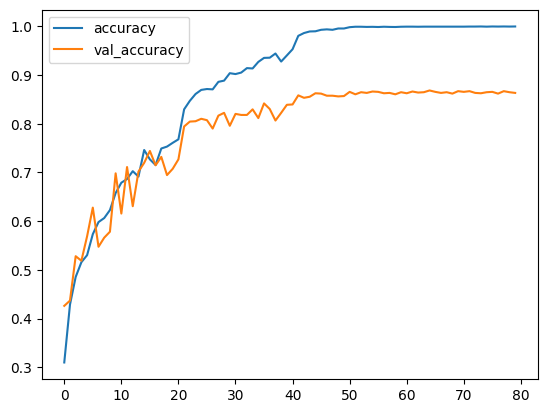

In [28]:
model_loss[['accuracy', 'val_accuracy']].plot()